# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the agents looks like:', states.shape)

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the agents looks like: (20, 33)


### 3. Build Models
First we define MLP-based actor and critic model.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    """Policy: state -> max action"""
    
    def __init__(self, state_size, action_size, seed):
        super(Actor, self).__init__()
        
        """
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, action_size)
        self.init_parameters()

    def init_parameters(self):
        torch.nn.init.uniform_(self.fc1.weight.data, *hidden_init(self.fc1))
        torch.nn.init.uniform_(self.fc2.weight.data, *hidden_init(self.fc2))
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic: state, action -> Q value"""
    
    def __init__(self, state_size, action_size, seed):
        super(Critic, self).__init__()
        
        """
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        
        torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512 + action_size, 256)
        self.fc3 = nn.Linear(256, 1)
        self.init_parameters()

    def init_parameters(self):
        torch.nn.init.uniform_(self.fcs1.weight.data, *hidden_init(self.fcs1))
        torch.nn.init.uniform_(self.fc2.weight.data, *hidden_init(self.fc2))
        torch.nn.init.uniform_(self.fc3.weight.data, -3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Define ReplayBuffer to store data and OUNoise for action generation.

In [6]:
import copy
import random
import numpy as np
from collections import namedtuple, deque


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.state = copy.copy(self.mu)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

Define the agent that interacts with and learns from the environment.

In [7]:
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_Actor = 1e-4         # learning rate 
LR_CRITIC = 1e-4        # learning rate


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, n_agents, state_size, action_size, seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            n_agents (int): number of agents
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            action_limit (int): dimension of each action
            seed (int): random seed
        """
        self.n_agents = n_agents
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Actor and critic
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
                
        # Optimizers
        self.optimizer_actor = optim.Adam(self.actor_local.parameters(), lr=LR_Actor)
        self.optimizer_critic = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        
        self.noise = OUNoise((self.n_agents, action_size), seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        # Save experience in replay memory
        for i in range(self.n_agents):
            self.memory.add(states[i, :], actions[i, :], rewards[i], next_states[i, :], dones[i])
        
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, eps):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            states (array_like): current state
        """
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        actions = np.zeros((self.n_agents, self.action_size))
        
        with torch.no_grad():
            for i_agent, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[i_agent, :] = action
        
        if random.random() < eps:
            actions += self.noise.sample()

        actions = np.clip(actions, -1.0, 1.0)
        
        return actions
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        self.actor_local.train()
        self.critic_local.train()
        
        states, actions, rewards, next_states, dones = experiences
        
        # ------------------- update critic ------------------- #
        state_action_values = self.critic_local(states, actions)
        
        with torch.no_grad():
            max_actions = self.actor_target(next_states)
            next_state_values = self.critic_target(next_states, max_actions)
        expected_state_action_values = (1 - dones) * (next_state_values * gamma) + rewards
        
        loss_critic = F.mse_loss(state_action_values, expected_state_action_values)
        
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()
        
        # ------------------- update actor ------------------- #
        self.critic_local.eval()
        for params in self.critic_local.parameters():
            params.requires_grad = False
        
        pred_actions = self.actor_local(states)
        loss_actor = -self.critic_local(states, pred_actions).mean()
        
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()
        
        for params in self.critic_local.parameters():
            params.requires_grad = True
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.soft_update(self.critic_local, self.critic_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 4. Initialize Agent and Train with DDPG

Episode 1	Episode Score: 0.58	 Average Score: 0.58
Episode 2	Episode Score: 0.60	 Average Score: 0.59
Episode 3	Episode Score: 0.91	 Average Score: 0.70
Episode 4	Episode Score: 0.54	 Average Score: 0.66
Episode 5	Episode Score: 1.01	 Average Score: 0.73
Episode 6	Episode Score: 0.73	 Average Score: 0.73
Episode 7	Episode Score: 0.89	 Average Score: 0.75
Episode 8	Episode Score: 1.21	 Average Score: 0.81
Episode 9	Episode Score: 1.58	 Average Score: 0.90
Episode 10	Episode Score: 2.56	 Average Score: 1.06
Episode 11	Episode Score: 2.40	 Average Score: 1.18
Episode 12	Episode Score: 3.36	 Average Score: 1.36
Episode 13	Episode Score: 4.69	 Average Score: 1.62
Episode 14	Episode Score: 5.91	 Average Score: 1.93
Episode 15	Episode Score: 4.76	 Average Score: 2.12
Episode 16	Episode Score: 3.69	 Average Score: 2.21
Episode 17	Episode Score: 5.94	 Average Score: 2.43
Episode 18	Episode Score: 7.73	 Average Score: 2.73
Episode 19	Episode Score: 11.23	 Average Score: 3.18
Episode 20	Episode S

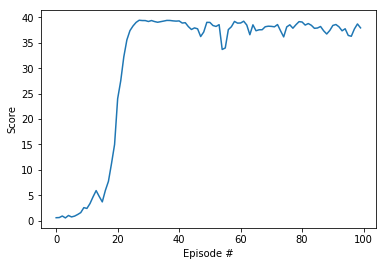

In [8]:
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


agent = Agent(num_agents, state_size, action_size)


def ddpg(n_episodes=150, eps_start=1.0, eps_end=0.01, eps_decay=0.95):
    """Deep Deterministic Policy Gradient.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    ddpg_scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        
        while True:
            actions = agent.act(states, eps)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        
        eps = max(eps_end, eps_decay*eps)
        episode_score = np.mean(scores)
        scores_window.append(episode_score)
        ddpg_scores.append(episode_score)
        avg_reward = np.mean(scores_window)

        print('\rEpisode {}\tEpisode Score: {:.2f}\t Average Score: {:.2f}'.format(i_episode, episode_score, avg_reward))
        
        if avg_reward >= 30.0 and i_episode >= 100:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_reward))
            torch.save(agent.actor_local.state_dict(), 'actor_ckpt.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_ckpt.pth')
            break
    
    return ddpg_scores

scores = ddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()